In [ ]:
!pip install kaggle

In [ ]:
# Import dependencies

# To read the file from kaggle
import os
import json

# To extract data from the zip file
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# To build the neural network
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Data Collection through Kaggle API

In [ ]:
kaggle_dict = json.load(open('kaggle.json')) # opens the file with kaggle credentials after converting it into a python dictionary

In [ ]:
kaggle_dict.keys() # Keys of the dictionary, whose values store the credientials itself.

dict_keys(['username', 'key'])

In [ ]:
# Setting kaggle API credentials as envirnment variables

os.environ['KAGGLE_USERNAME'] = kaggle_dict['username']
os.environ['KAGGLE_KEY'] = kaggle_dict['key']

In [ ]:
!kaggle datasets download -d ankurzing/sentiment-analysis-for-financial-news

Dataset URL: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
License(s): CC-BY-NC-SA-4.0
sentiment-analysis-for-financial-news.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

all-data.csv	     kaggle.json  sentiment-analysis-for-financial-news.zip
FinancialPhraseBank  sample_data


In [ ]:
# unzip the dataset file

#Unzips the dataset with the variable name zip_ref and extract them.
with ZipFile("sentiment-analysis-for-financial-news.zip", "r") as zip_ref:
    zip_ref.extractall()

In [ ]:
# Extracted file
!ls

all-data.csv	     kaggle.json  sentiment-analysis-for-financial-news.zip
FinancialPhraseBank  sample_data


### Loading the dataset

In [ ]:
data = pd.read_csv("/content/all-data.csv", encoding = "ISO-8859-1")
data.shape

(4845, 2)

In [ ]:
data.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [ ]:
cols = ['sentiment', 'news']

data = pd.read_csv("/content/all-data.csv", encoding = "ISO-8859-1", names = cols)
data.head()

,sentiment,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
# Observing the distribution of the target data

data['sentiment'].value_counts() # No data imbalance

,count
sentiment,
neutral,2879
positive,1363
negative,604


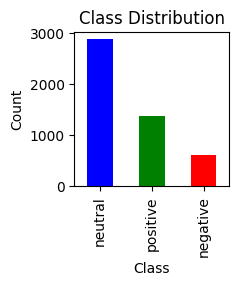

In [ ]:
plt.figure(figsize = (2, 2))
data['sentiment'].value_counts().plot(kind = 'bar', color = ['blue', 'green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
# encoding the target values

data.replace({'sentiment': {'neutral':2, 'positive': 1, 'negative': 0}}, inplace = True)
data['sentiment'].value_counts()

<ipython-input-34-b658cd0f69d7>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'sentiment': {'neutral':2, 'positive': 1, 'negative': 0}}, inplace = True)


,count
sentiment,
2,2879
1,1363
0,604


### Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
feature_extraction = TfidfVectorizer(min_df = 1, stop_words = 'english', lowercase = True)

X = feature_extraction.fit_transform(data['news'])
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7371134020618557


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.28      0.41       116
           1       0.72      0.48      0.57       275
           2       0.74      0.95      0.83       579

    accuracy                           0.74       970
   macro avg       0.74      0.57      0.60       970
weighted avg       0.74      0.74      0.71       970



In [ ]:
def predict_sentiment(review):
    review_vector = feature_extraction.transform([review])  # Transform the input text
    sentiment = lr.predict(review_vector)[0]  # Predict sentiment
    sentiment_label = {0: "Negative", 1: "Positive", 2: "Neutral"}  # Map sentiment
    return sentiment_label[sentiment]

# Example usage
review = "Gold prices are expected to rise amid inflation fears."
print(f"Sentiment: {predict_sentiment(review)}")

Sentiment: Neutral


### Data Preprocessing for LSTM

In [ ]:
# Splitting the dataset into training and testing data

train_df, test_df = train_test_split(data, test_size = 0.2, random_state = 20)

In [ ]:
print("Shape of Training data and label:", train_df.shape, test_df.shape)

Shape of Training data and label: (3876, 2) (970, 2)


In [ ]:
# Findind the average length of the news in the dataset
data['news_len'] = data['news'].apply(len)

print("Average length of the news: ", data['news_len'].mean())

Average length of the news:  128.1320676846884


In [ ]:
# Tokenise the text data - the words into integers

# Taking the top 5000 most frequently occurring words from the training data and converting them into integers based on their frequency.
tokenizer = Tokenizer(num_words = 5000)

# Analyzes the training data to determine the frequently occuring words.
# We fit only the training data to avoid data leakage - so the model learns from only the training data.
tokenizer.fit_on_texts(train_df['news'])

In [ ]:
# Converting WORDS in the data into a SEQUENCE of integera

# tokenizer.texts_to_sequences - replaces the words in 'news' with its respective integer from the tokenizer.
# If a word is not in the top 5000, then its ignored(or replaced with a special token)

# pad_sequence ensures all the news sequences have uniform length of 200, if not padding is done
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['news']), maxlen = 200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['news']), maxlen = 200)

In [ ]:
pd.set_option('display.max_colwidth', None)
print("The news:", train_df['news'].head(1))
print("\nThe tokenised news:", X_train[0])
print("\nThe length of the news:", len(X_train[0]))

The news: 1492    A PLUMBING business has announced it is sponsoring a professional darts player .
Name: news, dtype: object

The tokenised news: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

In [ ]:
y_train = train_df['sentiment']
y_test = test_df['sentiment']

### Building a LSTM Model for Sentiment Analysis (Long Short Term Memory) for sequential text

In [ ]:
# Creating a linear stack of layers where we can add more layers
model = Sequential()

# Embedding layer: Maps words to dense vector in a high-dimensional space
model.add(Embedding(input_dim = 5000, output_dim = 128))

# LSTM layer - Processes the sequential data while maintaining context
model.add(LSTM(units = 128, dropout = 0.4, recurrent_dropout = 0.4))

'''
dropout = 0.2: To prevent overfitting drops 20% of input units flows as 0.
'''

# Fully connected layer - Outputs a probability for classification
model.add(Dense(units = 3, activation = "softmax"))

In [ ]:
# Display the model summary

model.build(input_shape = (None, 200))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 771,971 (2.94 MB)

 Trainable params: 771,971 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

Layer 1:
Parameters =

`input_dim * output_dim`


embedding layer = 5000 * 128 = 640,000

Layer 2:
Parameters =

`4 * [(input_dim + units) * units + units]`

4 signifies the number of gates in LSTM. So,
4*[(128+128) * 128 + 128] = 131,584.

Layer 3:
Parameter:

` input_dim * output_dim + bias `

128 * 1 + 1 = 129



In [ ]:
# compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Training the model

In [ ]:
print(type(X_train))
print(type(y_train))

print(X_train.shape)
print(y_train.shape)

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
(3876, 200)
(3876,)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [ ]:
model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 46s 343ms/step - accuracy: 0.5840 - loss: 0.9555 - val_accuracy: 0.6598 - val_loss: 0.7908
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 35s 358ms/step - accuracy: 0.6595 - loss: 0.7270 - val_accuracy: 0.6843 - val_loss: 0.7378
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 366ms/step - accuracy: 0.7930 - loss: 0.5038 - val_accuracy: 0.7010 - val_loss: 0.7480
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 349ms/step - accuracy: 0.8638 - loss: 0.3628 - val_accuracy: 0.7345 - val_loss: 0.7607
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 337ms/step - accuracy: 0.9159 - loss: 0.2412 - val_accuracy: 0.7358 - val_loss: 0.8800


### Model Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test) # Finds y_pred, compares it with y_test (true label)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7207 - loss: 0.9457
Test Loss: 0.9460896253585815
Test Accuracy: 0.7288659811019897


Building a Predictive System

In [ ]:
def predict_Sentiment(review):

    # tokenise the review
    seq = tokenizer.texts_to_sequences([review])

    # Padding
    padded_seq = pad_sequences(seq, maxlen = 120)

    # Prediction
    pred = model.predict(padded_seq) # Example output: [[0.93625784 0.01929086 0.04445123]]

    # Output
    if pred[0][2] > 0.5:
        sentiment = "Neutral"
    elif pred[0][0] > 0.5:
        sentiment = "Negative"
    else:
        sentiment = "Positive"

    return pred, sentiment

In [ ]:
# example
review = "A tinyurl link takes users to a scamming site promising that users can earn thousands of dollars by becoming a Google ( NASDAQ : GOOG ) Cash advertiser ." # negative
sentiment = predict_Sentiment(review)
print("The sentiment of the review: ", sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
The sentiment of the review:  (array([[0.9223571 , 0.04264332, 0.03499965]], dtype=float32), 'Negative')


In [ ]:
# example_2
review = "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m ." # positive
sentiment = predict_Sentiment(review)
print("The sentiment of the review: ", sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
The sentiment of the review:  (array([[7.8416672e-03, 9.9175572e-01, 4.0272577e-04]], dtype=float32), 'Positive')


In [ ]:
# example_3
review = "According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing." # Neutral
sentiment = predict_Sentiment(review)
print("The sentiment of the review: ", sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
The sentiment of the review:  (array([[0.00981333, 0.01410748, 0.97607917]], dtype=float32), 'Neutral')


In [ ]:
# example_3"
review = "According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 %. "  # Positive
sentiment = predict_Sentiment(review)
print("The sentiment of the review: ", sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
The sentiment of the review:  (array([[8.5340743e-04, 3.0269658e-03, 9.9611962e-01]], dtype=float32), 'Neutral')


In [ ]:
review = "The company supports its global customers in developing new technologies and offers a fast route from product development to applications and volume production ."  # Neutral
sentiment = predict_Sentiment(review)
print("The sentiment of the review: ", sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
The sentiment of the review:  (array([[0.00155413, 0.00897259, 0.9894733 ]], dtype=float32), 'Neutral')
